In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
# Machine learning model output for domestic demand per capita
dpc = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\delivery_water_use_model\predictions\national_dpc_predictions.csv')
sdwis_facilities_nofilter = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\2020_WT_Facilities_Details.csv')
# Filtered for Treatment and include Facility Activity = Activity/Inactive
sdwis = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\SDWIS.csv')
# USGS 2017 data for WSA
usgs_wsa = gp.read_file(r'C:\Users\mhardika\Downloads\WSA_v1\WSA_v1\WSA_v1.shp')
# Census decennial release for 2020 state wise
decennial_pop = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\decennial_2020_state_pop.csv')
# Population data set
hauer_pop_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\pop_projection.csv')
hauer_pop_df = hauer_pop_df[~(hauer_pop_df == 0).any(axis=1)].reset_index(drop=True)

C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_1228\2212391072.py:3: DtypeWarning: Columns (9,16,17,26) have mixed types. Specify dtype option on import or set low_memory=False.
  sdwis_facilities_nofilter = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\2020_WT_Facilities_Details.csv')
C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_1228\2212391072.py:5: DtypeWarning: Columns (12,13,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  sdwis = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\SDWIS.csv')


In [3]:
# Make the wsa string with 9 characters

dpc_2020 = dpc.loc[dpc['year']==2020].copy()
dpc_2020.reset_index(inplace=True)
updated_column_list = []

for idx,row in dpc_2020.iterrows():
    try:
        a = int(row['wsa_agidf'])
        # print(f'{a:09d}')
        updated_column_list.append(str(f'{a:09d}'))
        # updated_column_list.append(row['wsa_agidf'])
    except:
        updated_column_list.append(row['wsa_agidf'].upper())

dpc_2020['wsa_agidf'] = updated_column_list
dpc_2020 = dpc_2020.rename(columns={'wsa_agidf':'PWS ID'})
dpc_2020_trimmed = dpc_2020[['PWS ID','year','population','lat','lon','dpc_0']].copy()
# dpc_2020_trimmed['avg_dpc'] = 
dpc_2020_trimmed.head(5)

,PWS ID,year,population,lat,lon,dpc_0
0,010106001,2020,390.0,41.464460,-71.974754,87.491610
1,CT0012011,2020,130.0,41.744020,-72.376473,61.693726
2,CT0030011,2020,90.0,41.844122,-72.176009,55.963350
3,CT0030021,2020,100.0,41.880964,-72.167671,85.623314
4,CT0030041,2020,85.0,41.870672,-72.148216,81.320244


In [4]:
# Change PWS IDs to 9 digit strings
correct_rows = sdwis_facilities_nofilter.loc[sdwis_facilities_nofilter['PWS ID'].str.contains(r'^\d+$')]

updated_column_list = []
idx_list = []
for idx,row in correct_rows.iterrows():
    try:
        a = int(row['PWS ID'])
        idx_list.append(idx)
        # print(f'{a:09d}')
        updated_column_list.append(str(f'{a:09d}'))
        # updated_column_list.append(row['wsa_agidf'])
    except:
        print('Problem!')

# correct_rows['PWS ID'] = updated_column_list
# Correcting dataframe
new_df = pd.DataFrame({'PWS ID': updated_column_list}, index = idx_list)
# new_df
sdwis_facilities_nofilter_updated = sdwis_facilities_nofilter.copy()
sdwis_facilities_nofilter_updated.update(new_df)
sdwis_facilities_nofilter_updated.head(5)

,PWS ID,PWS Name,EPA Region,Primacy Agency,PWS Type,Primacy Type,Owner Type,Primary Source,Activity Status,Deactivation Date,...,Fax Number,Alt Phone Number,Address Line1,Address Line2,City Name,State Code,Zip Code,Country Code,First Reported Date,Last Reported Date
0,MN1250021,Dennison,Region 5,Minnesota,Community water system,State,Local government,Ground water,Active,NaN,...,NaN,NaN,Dennison City Hall,P.O. Box 56,Dennison,MN,55018,US,7-Feb-83,9-Dec-20
1,MN1260001,Ashby,Region 5,Minnesota,Community water system,State,Local government,Ground water,Active,NaN,...,NaN,NaN,Ashby City Hall,203 West Main,Ashby,MN,56309,US,24-Jan-81,9-Dec-20
2,MN1260002,Barrett,Region 5,Minnesota,Community water system,State,Local government,Ground water,Active,NaN,...,NaN,NaN,P.O. Box 155,NaN,Barrett,MN,56311,US,24-Jan-81,9-Dec-20
3,MN1260003,Elbow Lake,Region 5,Minnesota,Community water system,State,Local government,Ground water,Active,NaN,...,NaN,NaN,Elbow Lake City Hall,P.O. Box 1079,Elbow Lake,MN,56531,US,24-Jan-81,9-Dec-20
4,IL1195210,MITCHELL PWD,Region 5,Illinois,Community water system,State,Local government,Surface water purchased,Active,NaN,...,618-931-7625,NaN,745 EAST CHAIN OF ROCK ROAD,P.O. BOX 8125,GRANITE CITY,IL,62040,US,13-Feb-81,15-Dec-20


In [5]:
# Clean up SDWIS

number = []
alphanumeric = []
idx_list = []
# Assign state code where missing
check = sdwis_facilities_nofilter.loc[sdwis_facilities_nofilter['State Code'].isnull()].copy()
for pws in check['PWS ID']:
    try:
        number.append(int(pws))
    except:
        alphanumeric.append(pws)
sdwis_facilities_nofilter.head(5)

print('Checking how many numbered facilities cannot be assigned a state code based on facility PWS ID')
print('Number only PWS IDs:',len(number))
print('Alphanumeric PWS IDs',len(alphanumeric))

Checking how many numbered facilities cannot be assigned a state code based on facility PWS ID
Number only PWS IDs: 91
Alphanumeric PWS IDs 9020


In [8]:
# Merge DPC with SDWIS dataset with no filter
common_df = dpc_2020_trimmed.merge(sdwis_facilities_nofilter_updated, how='left', on ='PWS ID')
# To check merge was ok
print(len(common_df))
print(len(dpc_2020_trimmed))
print(len(sdwis_facilities_nofilter_updated.drop_duplicates()))

18807
18807
425282


In [298]:
# Correct state code assignment in the merged file based on PWS ID
wrong_state_idx_list=[]
state_list = []

for idx, row in common_df.iterrows():
    # print(row['PWS ID'][0:2])

    if row['PWS ID'][0:2].isalpha():
        # print(row['PWS ID'][0:2])
        if row['PWS ID'][0:2]!= row['State Code']:
            # print(row)
            wrong_state_idx_list.append(idx)
            state_list.append(row['PWS ID'][0:2])

print(len(wrong_state_idx_list))

# Correcting dataframe
new_df = pd.DataFrame({'State Code': state_list}, index = wrong_state_idx_list)
# new_df
common_df_updated = common_df.copy()
common_df_updated.update(new_df)


209


In [299]:
# List of facilities without a state code
common_df_updated[common_df_updated['State Code'].isnull()]

,PWS ID,year,population,lat,lon,dpc_0,PWS Name,EPA Region,Primacy Agency,PWS Type,...,Fax Number,Alt Phone Number,Address Line1,Address Line2,City Name,State Code,Zip Code,Country Code,First Reported Date,Last Reported Date
2042,905045000000499,2020,132.0,35.223596,-92.123979,73.437870,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5463,94900700012,2020,137.0,39.719830,-111.162247,67.476300,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5464,94900700013,2020,55.0,39.643337,-111.154828,53.298073,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9399,430516073353600,2020,681.0,43.091848,-73.591757,46.364544,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9400,936000000355,2020,18612.0,40.668607,-73.510445,71.385270,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15806,95502100020,2020,2838.0,43.633667,-89.775198,44.774900,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15807,95502500066,2020,28784.0,42.985850,-89.425503,44.925250,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
# List of facilities not in the SDWIS no filter set
common_df_updated[common_df_updated['Activity Status'].isnull()]

,PWS ID,year,population,lat,lon,dpc_0,PWS Name,EPA Region,Primacy Agency,PWS Type,...,Fax Number,Alt Phone Number,Address Line1,Address Line2,City Name,State Code,Zip Code,Country Code,First Reported Date,Last Reported Date
2042,905045000000499,2020,132.0,35.223596,-92.123979,73.437870,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5463,94900700012,2020,137.0,39.719830,-111.162247,67.476300,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5464,94900700013,2020,55.0,39.643337,-111.154828,53.298073,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9399,430516073353600,2020,681.0,43.091848,-73.591757,46.364544,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9400,936000000355,2020,18612.0,40.668607,-73.510445,71.385270,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15806,95502100020,2020,2838.0,43.633667,-89.775198,44.774900,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15807,95502500066,2020,28784.0,42.985850,-89.425503,44.925250,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


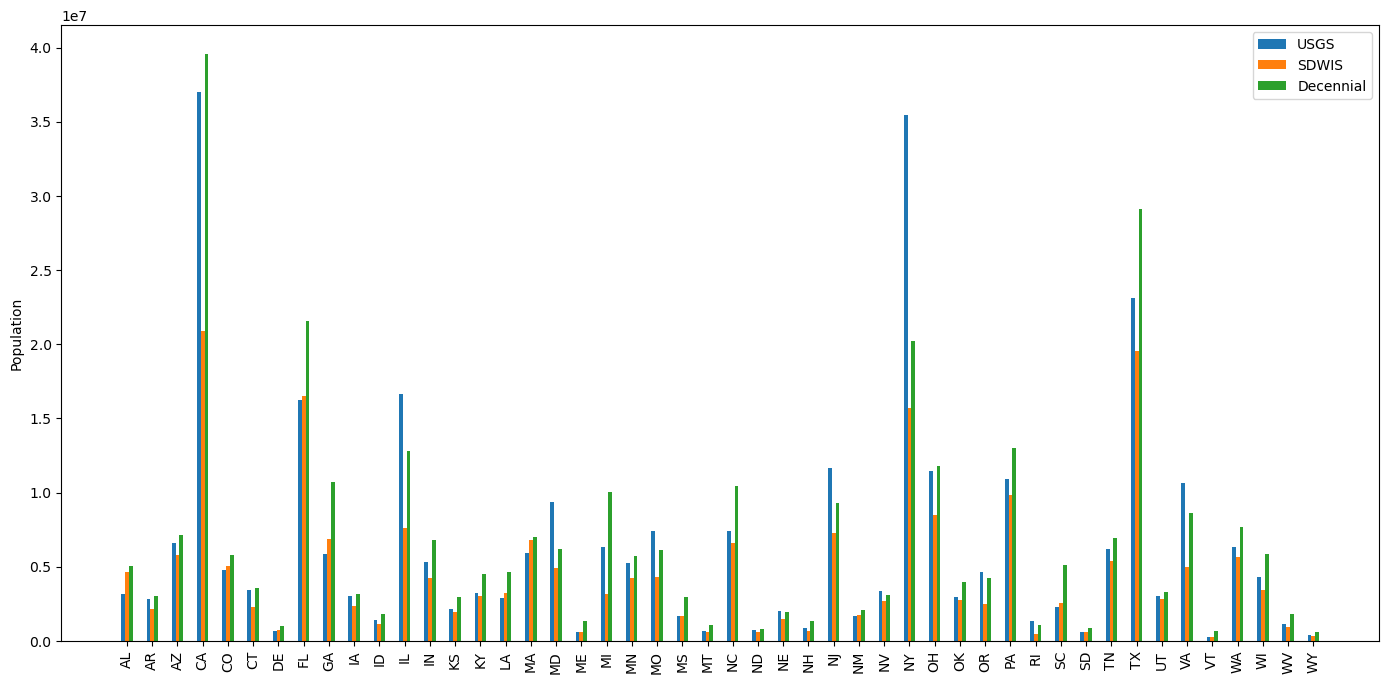

In [320]:
# Compare population between decennial and DPC

dpc_pop = common_df_updated.groupby('State Code')['population'].sum().to_frame()
sdwis_pop = common_df_updated.groupby('State Code')['Population Served Count'].sum().to_frame()
pop_comparison= dpc_pop.merge(decennial_pop,how='left', left_on = 'State Code', right_on ='state_code').dropna()
pop_comparison = pop_comparison.merge(sdwis_pop,how='left', right_on = 'State Code', left_on ='state_code').dropna()

x = np.arange(0,len(pop_comparison))
fig,ax = plt.subplots(figsize=(17,8))
ax.bar(x-0.15, pop_comparison['population'].values, width = 0.15,label='USGS')
ax.bar(x, pop_comparison['Population Served Count'].values, width = 0.15,label='SDWIS')
ax.bar(x+0.15, pop_comparison['Population'].values,width = 0.15,label='Decennial')

ax.set_xticks(range(0,len(pop_comparison)),pop_comparison['state_code'],rotation = 90)
ax.set_ylabel('Population')
ax.legend()

In [310]:
# Checking the treatment sdwis data with activity status=active and facility activity = active/inactive
# Facility activity represents if the unit process is active
# Drop duplicates - splitting the list to avoid accidentally dropping some facilitiy activity=active
sdwis_active = sdwis.loc[sdwis['Facility Activity']=='Active']
sdwis_active = sdwis_active.drop_duplicates('PWS ID')

sdwis_inactive = sdwis.loc[sdwis['Facility Activity']=='Inactive']
sdwis_inactive = sdwis_inactive.drop_duplicates(subset=['PWS ID'])

print('Active:', len(sdwis_active))
print('Inactive:', len(sdwis_inactive))

# Make sure the number only PWS IDs have 9 digits

updated_column_list = []
for idx,row in sdwis_active.iterrows():
    try:
        a = int(row['PWS ID'])
        # print(f'{a:09d}')
        updated_column_list.append(str(f'{a:09d}'))
    except:
        updated_column_list.append(row['PWS ID'])

sdwis_active['PWS ID'] = updated_column_list

updated_column_list = []
for idx,row in sdwis_inactive.iterrows():
    try:
        a = int(row['PWS ID'])
        # print(f'{a:09d}')
        updated_column_list.append(str(f'{a:09d}'))
    except:
        updated_column_list.append(row['PWS ID'])

sdwis_inactive['PWS ID'] = updated_column_list


# Make list of facility activity status. If it is neither active nor inactive it may not be a treatment facility
facility_active = []

for idx,row in common_df_updated.iterrows():
        if row['PWS ID'] in sdwis_active['PWS ID'].values:
            facility_active.append('Active')
        elif row['PWS ID'] in sdwis_inactive['PWS ID'].values: 
            facility_active.append('Inactive')
        else:
            facility_active.append('Not Treatment')

print(len(facility_active))

# facility_active

Active: 36175
Inactive: 10964
18807


In [9]:
36175+ 10964

47139

In [307]:
if '010106001' in sdwis_active['PWS ID']:
    print('ok')

In [311]:
common_df_updated['Facility Activity'] = facility_active

In [322]:
# Active facilities listed in common df
print('SDWIS Not filtered:', len(sdwis_facilities_nofilter))
print('DPC:',len(common_df_updated))
common_df_updated_active = common_df_updated.loc[common_df_updated['Activity Status']=='Active']
print('Plant Active facilities:', len(common_df_updated_active))

# CWS facilities
common_df_cws_active = common_df_updated_active.loc[common_df_updated_active['PWS Type']=='Community water system']
common_df_cws = common_df_updated.loc[common_df_updated['PWS Type']=='Community water system']
print('Plant Active CWS facilities:', len(common_df_cws_active))
print('CWS facilities (Active + Inactive):', len(common_df_cws))

common_df_treatment_active = common_df_updated_active.loc[common_df_updated_active['Facility Activity']=='Active']
common_df_treatment_inactive = common_df_updated_active.loc[common_df_updated_active['Facility Activity']=='Inactive']
common_df_not_treatment = common_df_updated_active.loc[common_df_updated_active['Facility Activity']=='Not Treatment']
print('Plant Active and Facility active:',len(common_df_treatment_active))
print('Plant Active and Facility inactive:',len(common_df_treatment_inactive))
print('Facility (in USGS, in Facilities detailed report but not SDWIS Facilities Report) not in treatment list:',len(common_df_not_treatment))

SDWIS Not filtered: 425282
DPC: 18807
Plant Active facilities: 18477
Plant Active CWS facilities: 18442
CWS facilities (Active + Inactive): 18759
Plant Active and Facility active: 16524
Plant Active and Facility inactive: 452
Facility (in USGS, in Facilities detailed report but not SDWIS Facilities Report) not in treatment list: 1501


In [319]:
common_df_updated_active.loc[common_df_updated_active['Facility Activity']=='Not Treatment'].iloc[0]

PWS ID                                                   CT0030021
year                                                          2020
population                                                   100.0
lat                                                      41.880964
lon                                                     -72.167671
dpc_0                                                    85.623314
PWS Name                        PERRY HILL ESTATES APARTMENTS INC.
EPA Region                                                Region 1
Primacy Agency                                         Connecticut
PWS Type                                    Community water system
Primacy Type                                                 State
Owner Type                                                 Private
Primary Source                                        Ground water
Activity Status                                             Active
Deactivation Date                                             